# Classification. Decision Tree 6133 Тюгаев Никита Павлович

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from ucimlrepo import fetch_ucirepo

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)


import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)
sns.set_style("white")
sns.set_context("notebook", font_scale=1.2)

#### 1. Считать в `pandas.DataFrame` любой источник данных: CSV, JSON, Excel-файл, HTML-таблицу и т.п.

In [2]:
automobile = fetch_ucirepo(id=10)

df = pd.concat([automobile.data.features, automobile.data.targets], axis=1).replace(
    "?", np.nan
)

variable_info = automobile.variables.drop(
    columns=["role", "demographic", "units", "missing_values"]
)

#### 2. Датасет и подготовка данных:
   - Привести описание датасета.
   - Осуществить предобработку данных (избавиться от `null`, убрать некоторые признаки и т.п.) - "подчистить данные".
   - Закодировать категориальные признаки при необходимости.
   - Нормализовать данные.
   - Разбить выборку на обучающую и тестовую.
     > Далее используем обучающую выборку, в том числе для метрик.

##### Привести описание датасета.

**Датасет UCI ML Automobile содержит информацию об автомобилях и их атрибутах, включающими как категориальные признаки (марка, тип топлива, тип кузова), так и числовые характеристики (мощность двигателя, расход топлива, габариты). При использовании страхового риска (symboling) в качестве целевой переменной задача сводится к классификации, где требуется классифицировать уровень риска на основе его технических характеристик и других параметров.**

In [3]:
display(variable_info)

,name,type,description
0,price,Continuous,continuous from 5118 to 45400
1,highway-mpg,Continuous,continuous from 16 to 54
2,city-mpg,Continuous,continuous from 13 to 49
3,peak-rpm,Continuous,continuous from 4150 to 6600
4,horsepower,Continuous,continuous from 48 to 288
5,compression-ratio,Continuous,continuous from 7 to 23
6,stroke,Continuous,continuous from 2.07 to 4.17
7,bore,Continuous,continuous from 2.54 to 3.94
8,fuel-system,Categorical,"1bbl, 2bbl, 4bbl, idi, mfi, mpfi, spdi, spfi"
9,engine-size,Continuous,continuous from 61 to 326


##### Осуществить предобработку данных (избавиться от `null`, убрать некоторые признаки и т.п.) - "подчистить данные".

In [4]:
print("Количество пропущенных значений в каждом столбце:")
display(df.isnull().sum())

Количество пропущенных значений в каждом столбце:


price                 4
highway-mpg           0
city-mpg              0
peak-rpm              2
horsepower            2
compression-ratio     0
stroke                4
bore                  4
fuel-system           0
engine-size           0
num-of-cylinders      0
engine-type           0
curb-weight           0
height                0
width                 0
length                0
wheel-base            0
engine-location       0
drive-wheels          0
body-style            0
num-of-doors          2
aspiration            0
fuel-type             0
make                  0
normalized-losses    41
symboling             0
dtype: int64

In [5]:
categorical_cols = (
    variable_info[variable_info["type"].isin(["Integer", "Categorical", "Binary"])]
    .iloc[:-1]["name"]
    .to_list()
)
numerical_cols = variable_info[variable_info["type"].isin(["Continuous"])][
    "name"
].to_list()

for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print(
    "Количество пропущенных значений в каждом столбце после заполнения пропущенных значений:"
)
display(df.isnull().sum())

Количество пропущенных значений в каждом столбце после заполнения пропущенных значений:


price                0
highway-mpg          0
city-mpg             0
peak-rpm             0
horsepower           0
compression-ratio    0
stroke               0
bore                 0
fuel-system          0
engine-size          0
num-of-cylinders     0
engine-type          0
curb-weight          0
height               0
width                0
length               0
wheel-base           0
engine-location      0
drive-wheels         0
body-style           0
num-of-doors         0
aspiration           0
fuel-type            0
make                 0
normalized-losses    0
symboling            0
dtype: int64

##### Закодировать категориальные признаки при необходимости.

In [6]:
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print(f"Количество признаков до кодирования: {df.shape[1]}")
print(f"Количество признаков после кодирования: {df_encoded.shape[1]}")

Количество признаков до кодирования: 26
Количество признаков после кодирования: 66


##### Разбить выборку на обучающую и тестовую.

In [7]:
X = df_encoded.drop("symboling", axis=1)
y = df_encoded["symboling"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (153, 65)
Размер тестовой выборки: (52, 65)


##### Нормализовать данные.

In [8]:
mm_scaler = StandardScaler()

mm_scaled_x_train = pd.DataFrame(
    mm_scaler.fit_transform(X_train), columns=X_train.columns
)
mm_scaled_x_test = pd.DataFrame(mm_scaler.transform(X_test), columns=X_test.columns)

feature_names = mm_scaled_x_train.columns

#### 3. Дерево решений:
   - С использованием `GridSearchCV` осуществить подбор гиперпараметра `DecisionTreeClassifier` (как минимум `max_depth`, `max_features`, другие параметры - по желанию.)
   - Вывести значения гиперпараметра и метрик для наилучшей модели `DecisionTreeClassifier` ($accuracy$, $precision$, $recall$, $\textit{f-measure}$).
   - Для полученного наилучшего дерева вывести `feature_importances`, отсортировать их по убыванию.
   - Осуществить фильтрацию признаков (по какому-нибудь значению порога важности признака).
   - Подобрать лучшую модель с использованием `GridSearchCV` на обучающей выборке с отфильтрованными признаками.
   - Вывести полученные гиперпараметры лучшей модели.
   - Сравнить метрики до и после фильтрации признаков лучших моделей.

##### С использованием `GridSearchCV` осуществить подбор гиперпараметра `DecisionTreeClassifier` (как минимум `max_depth`, `max_features`, другие параметры - по желанию.)

In [9]:
tree_param_grid = {
    "max_depth": [3, 5, 7, 9, 11, 13, 15, None],
    "max_features": ["sqrt", "log2", None],
    "min_samples_split": [2, 5, 10],
    "criterion": ["gini", "entropy"],
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=tree_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)

grid_search.fit(mm_scaled_x_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_


y_pred = best_model.predict(mm_scaled_x_test)

##### Вывести значения гиперпараметра и метрик для наилучшей модели `DecisionTreeClassifier` ($accuracy$, $precision$, $recall$, $\textit{f-measure}$).

In [10]:
print("Наилучшие гиперпараметры:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Наилучшие гиперпараметры:
criterion: gini
max_depth: 11
max_features: None
min_samples_split: 2


##### Для полученного наилучшего дерева вывести `feature_importances`, отсортировать их по убыванию.

In [11]:
feature_importances = best_model.feature_importances_

importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances}
)
importance_df = importance_df.sort_values("Importance", ascending=False)

print("\nВажность признаков (отсортировано по убыванию):")
display(importance_df)


Важность признаков (отсортировано по убыванию):


,Feature,Importance
14,normalized-losses,0.238
13,wheel-base,0.188
8,engine-size,0.083
41,num-of-doors_4.0,0.080
10,height,0.073
...,...,...
36,drive-wheels_rwd,0.000
37,body-style_hardtop,0.000
38,body-style_hatchback,0.000
16,fuel-system_4bbl,0.000


##### Осуществить фильтрацию признаков (по какому-нибудь значению порога важности признака).

In [12]:
threshold = 0.01
important_features_mask = feature_importances > threshold
important_features_indices = np.where(important_features_mask)[0]

print(
    f"\nКоличество признаков после фильтрации (с порогом {threshold}): {len(important_features_indices)}"
)

important_features = importance_df[important_features_mask].Feature.to_list()


print("Отобранные признаки:")
print(*important_features, sep="\n")


Количество признаков после фильтрации (с порогом 0.01): 16
Отобранные признаки:
wheel-base
engine-size
bore
body-style_sedan
width
make_mitsubishi
city-mpg
stroke
highway-mpg
engine-type_ohcv
length
make_peugot
make_volkswagen
fuel-system_2bbl
fuel-system_spdi
body-style_wagon


##### Подобрать лучшую модель с использованием `GridSearchCV` на обучающей выборке с отфильтрованными признаками.

In [13]:
X_train_filtered = mm_scaled_x_train[important_features]
X_test_filtered = mm_scaled_x_test[important_features]

grid_search_filtered = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=tree_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)

grid_search_filtered.fit(X_train_filtered, y_train)

best_model_filtered = grid_search_filtered.best_estimator_
best_params_filtered = grid_search_filtered.best_params_

y_pred_filtered = best_model_filtered.predict(X_test_filtered)

##### Вывести полученные гиперпараметры лучшей модели.

In [14]:
print("\nНаилучшие гиперпараметры после фильтрации признаков:")
for param, value in best_params_filtered.items():
    print(f"{param}: {value}")


Наилучшие гиперпараметры после фильтрации признаков:
criterion: gini
max_depth: 7
max_features: None
min_samples_split: 5


##### Сравнить метрики до и после фильтрации признаков лучших моделей.

In [15]:
def calculate_metrics(y_true, y_pred, model_name):
    metrics = {
        "model_name": model_name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="macro"),
        "recall": recall_score(y_true, y_pred, average="macro"),
        "f1": f1_score(y_true, y_pred, average="macro"),
    }

    print(f"\nМетрики модели: {model_name}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-measure: {metrics['f1']:.4f}")

    # Добавляем вывод classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    return metrics

In [16]:
metrics_not_filtered = calculate_metrics(y_test, y_pred, "Лучшая модель")
metrics_filtered = calculate_metrics(
    y_test, y_pred_filtered, "Лучшая модель с отфильтрованными признаками"
)


Метрики модели: Лучшая модель
Accuracy: 0.7692
Precision: 0.8055
Recall: 0.8388
F1-measure: 0.8057

Classification Report:
              precision    recall  f1-score   support

          -2       1.00      1.00      1.00         1
          -1       0.83      1.00      0.91         5
           0       0.93      0.76      0.84        17
           1       0.82      0.64      0.72        14
           2       0.71      0.62      0.67         8
           3       0.54      1.00      0.70         7

    accuracy                           0.77        52
   macro avg       0.81      0.84      0.81        52
weighted avg       0.81      0.77      0.77        52


Метрики модели: Лучшая модель с отфильтрованными признаками
Accuracy: 0.6538
Precision: 0.5339
Recall: 0.5349
F1-measure: 0.5271

Classification Report:
              precision    recall  f1-score   support

          -2       0.00      0.00      0.00         1
          -1       0.43      0.60      0.50         5
           0    

In [17]:
decision_tree_df = pd.DataFrame(
    [metrics_not_filtered, metrics_filtered],
    columns=list(metrics_not_filtered.keys()),
)

decision_tree_df["model_type"] = "Decision Tree"
decision_tree_df["model"] = best_model, best_model_filtered
decision_tree_df["features"] = (
    X_train.columns.to_list(),
    X_train_filtered.columns.to_list(),
)

In [18]:
decision_tree_df.iloc[:, :-3]

,model_name,accuracy,precision,recall,f1
0,Лучшая модель,0.769,0.805,0.839,0.806
1,Лучшая модель с отфильтрованными признаками,0.654,0.534,0.535,0.527


**Отбор признаков по трешхолду 0.01 ухудшил метрики**

#### 4. Случайный лес
   - Построить случайный лес (`RandomForestClassifier`), c использованием `GridSearchCV` осуществить подбор гиперпараметра.
   - Вывести полученные гиперпараметры лучшей модели случайного леса.
   - Осуществить фильтрацию признаков.
   - Подобрать лучшую модель с использованием `GridSearchCV` на обучающей выборке с отфильтрованными признаками.
   - Вывести полученные гиперпараметры лучшей модели случайного леса.
   - Сравнить метрики до и после фильтрации признаков лучших моделей.

##### Построить случайный лес (`RandomForestClassifier`), c использованием `GridSearchCV` осуществить подбор гиперпараметра.

In [19]:
rf_param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)

grid_search.fit(mm_scaled_x_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

y_pred = best_model.predict(mm_scaled_x_test)

##### Вывести полученные гиперпараметры лучшей модели.

In [20]:
print("Наилучшие гиперпараметры:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Наилучшие гиперпараметры:
bootstrap: False
max_depth: None
min_samples_leaf: 1
min_samples_split: 5
n_estimators: 100


##### Осуществить фильтрацию признаков.

In [21]:
feature_importances = best_model.feature_importances_

importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances}
)
importance_df = importance_df.sort_values("Importance", ascending=False)

print("\nВажность признаков (отсортировано по убыванию):")
display(importance_df)


Важность признаков (отсортировано по убыванию):


,Feature,Importance
13,wheel-base,0.103
11,width,0.086
14,normalized-losses,0.079
10,height,0.072
41,num-of-doors_4.0,0.056
...,...,...
33,engine-type_rotor,0.000
34,engine-location_rear,0.000
57,make_plymouth,0.000
59,make_renault,0.000


In [22]:
threshold = 0.01
important_features_mask = feature_importances > threshold
important_features_indices = np.where(important_features_mask)[0]

print(
    f"\nКоличество признаков после фильтрации (с порогом {threshold}): {len(important_features_indices)}"
)

important_features = importance_df[important_features_mask].Feature.to_list()


print("Отобранные признаки:")
print(*important_features, sep="\n")


Количество признаков после фильтрации (с порогом 0.01): 20
Отобранные признаки:
wheel-base
width
normalized-losses
height
num-of-doors_4.0
length
curb-weight
price
bore
city-mpg
horsepower
engine-size
compression-ratio
peak-rpm
highway-mpg
body-style_wagon
aspiration_turbo
engine-type_ohcf
make_plymouth
fuel-system_mfi


##### Подобрать лучшую модель с использованием `GridSearchCV` на обучающей выборке с отфильтрованными признаками.

In [23]:
X_train_filtered = mm_scaled_x_train[important_features]
X_test_filtered = mm_scaled_x_test[important_features]

grid_search_filtered = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)

grid_search_filtered.fit(X_train_filtered, y_train)

best_model_filtered = grid_search_filtered.best_estimator_
best_params_filtered = grid_search_filtered.best_params_

y_pred_filtered = best_model_filtered.predict(X_test_filtered)

##### Вывести полученные гиперпараметры лучшей модели случайного леса.

In [24]:
print("\nНаилучшие гиперпараметры после фильтрации признаков:")
for param, value in best_params_filtered.items():
    print(f"{param}: {value}")


Наилучшие гиперпараметры после фильтрации признаков:
bootstrap: False
max_depth: None
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 50


##### Сравнить метрики до и после фильтрации признаков лучших моделей.

In [25]:
metrics_not_filtered = calculate_metrics(y_test, y_pred, "Лучшая модель")
metrics_filtered = calculate_metrics(
    y_test, y_pred_filtered, "Лучшая модель с отфильтрованными признаками"
)


Метрики модели: Лучшая модель
Accuracy: 0.7885
Precision: 0.6691
Recall: 0.6917
F1-measure: 0.6576

Classification Report:
              precision    recall  f1-score   support

          -2       0.00      0.00      0.00         1
          -1       0.62      1.00      0.77         5
           0       0.79      0.88      0.83        17
           1       0.90      0.64      0.75        14
           2       1.00      0.62      0.77         8
           3       0.70      1.00      0.82         7

    accuracy                           0.79        52
   macro avg       0.67      0.69      0.66        52
weighted avg       0.81      0.79      0.78        52


Метрики модели: Лучшая модель с отфильтрованными признаками
Accuracy: 0.7692
Precision: 0.6590
Recall: 0.6709
F1-measure: 0.6415

Classification Report:
              precision    recall  f1-score   support

          -2       0.00      0.00      0.00         1
          -1       0.71      1.00      0.83         5
           0    

In [26]:
random_forest_df = pd.DataFrame(
    [metrics_not_filtered, metrics_filtered],
    columns=list(metrics_not_filtered.keys()),
)

random_forest_df["model_type"] = "Random Forest"
random_forest_df["model"] = best_model, best_model_filtered
random_forest_df["features"] = (
    X_train.columns.to_list(),
    X_train_filtered.columns.to_list(),
)

In [27]:
random_forest_df.iloc[:, :-3]

,model_name,accuracy,precision,recall,f1
0,Лучшая модель,0.788,0.669,0.692,0.658
1,Лучшая модель с отфильтрованными признаками,0.769,0.659,0.671,0.642


**Отбор признаков по трешхолду 0.01 ухудшил метрики**

#### 5. Метод ближайших соседей:
   - С использованием `GridSearchCV` осуществить подбор гиперпараметра `KNeighborsClassifier` (`n_neighbors`).
   - Вывести значения гиперпараметра и метрик для наилучшей модели.
   - Осуществить фильтрацию признаков.
   - Подобрать лучшую модель с использованием `GridSearchCV` на обучающей выборке с отфильтрованными признаками.
   - Вывести полученные гиперпараметры лучшей модели.
   - Сравнить метрики до и после фильтрации признаков.

##### С использованием `GridSearchCV` осуществить подбор гиперпараметра `KNeighborsClassifier` (`n_neighbors`).

In [28]:
kneighbors_param_grid = {
    "n_neighbors": list(range(1, 31)),  # от 1 до 30 соседей
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "minkowski"],
}

grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=kneighbors_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)

grid_search.fit(mm_scaled_x_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_


y_pred = best_model.predict(mm_scaled_x_test)

##### Вывести значения гиперпараметра и метрик для наилучшей модели.

In [29]:
print("Наилучшие гиперпараметры:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Наилучшие гиперпараметры:
metric: manhattan
n_neighbors: 1
weights: uniform


##### Осуществить фильтрацию признаков.

In [30]:
sfs = SequentialFeatureSelector(
    best_model, n_features_to_select=15, direction="forward", scoring="accuracy", cv=5
)
sfs.fit(mm_scaled_x_train, y_train)

selected_features_mask = sfs.get_support()
selected_features = [
    feature_names[i] for i in range(len(feature_names)) if selected_features_mask[i]
]
print("Выбранные признаки (SFS):", *selected_features, sep="\n")

Выбранные признаки (SFS):
length
wheel-base
normalized-losses
fuel-system_4bbl
fuel-system_mfi
fuel-system_spfi
engine-type_ohcf
engine-type_rotor
engine-location_rear
num-of-doors_4.0
make_audi
make_mercury
make_peugot
make_renault
make_toyota


##### Подобрать лучшую модель с использованием `GridSearchCV` на обучающей выборке с отфильтрованными признаками.

In [31]:
X_train_filtered = mm_scaled_x_train[selected_features]
X_test_filtered = mm_scaled_x_test[selected_features]

grid_search_filtered = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=kneighbors_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)

grid_search_filtered.fit(X_train_filtered, y_train)

best_model_filtered = grid_search_filtered.best_estimator_
best_params_filtered = grid_search_filtered.best_params_

y_pred_filtered = best_model_filtered.predict(X_test_filtered)

##### Вывести полученные гиперпараметры лучшей модели.

In [32]:
print("\nНаилучшие гиперпараметры после фильтрации признаков:")
for param, value in best_params_filtered.items():
    print(f"{param}: {value}")


Наилучшие гиперпараметры после фильтрации признаков:
metric: euclidean
n_neighbors: 1
weights: uniform


##### Сравнить метрики до и после фильтрации признаков.

In [33]:
metrics_not_filtered = calculate_metrics(y_test, y_pred, "Лучшая модель")
metrics_filtered = calculate_metrics(
    y_test, y_pred_filtered, "Лучшая модель с отфильтрованными признаками"
)


Метрики модели: Лучшая модель
Accuracy: 0.7692
Precision: 0.6254
Recall: 0.6560
F1-measure: 0.6306

Classification Report:
              precision    recall  f1-score   support

          -2       0.00      0.00      0.00         1
          -1       0.62      1.00      0.77         5
           0       0.79      0.88      0.83        17
           1       0.91      0.71      0.80        14
           2       0.71      0.62      0.67         8
           3       0.71      0.71      0.71         7

    accuracy                           0.77        52
   macro avg       0.63      0.66      0.63        52
weighted avg       0.77      0.77      0.76        52


Метрики модели: Лучшая модель с отфильтрованными признаками
Accuracy: 0.8269
Precision: 0.8591
Recall: 0.8694
F1-measure: 0.8559

Classification Report:
              precision    recall  f1-score   support

          -2       1.00      1.00      1.00         1
          -1       0.83      1.00      0.91         5
           0    

In [34]:
kneighbors_df = pd.DataFrame(
    [metrics_not_filtered, metrics_filtered],
    columns=list(metrics_not_filtered.keys()),
)

kneighbors_df["model_type"] = "KNeighbors"
kneighbors_df["model"] = best_model, best_model_filtered
kneighbors_df["features"] = (
    X_train.columns.to_list(),
    X_train_filtered.columns.to_list(),
)

In [35]:
kneighbors_df.iloc[:, :-3]

,model_name,accuracy,precision,recall,f1
0,Лучшая модель,0.769,0.625,0.656,0.631
1,Лучшая модель с отфильтрованными признаками,0.827,0.859,0.869,0.856


**Отбор признаков улучшил метрики**

#### 6. Если наблюдается улучшение метрик после фильтрации признаков хотя бы для одной из моделей, то для набора отфильтрованных признаков (пересечение множеств отфильтрованных признаков каждой модели или объединение множеств &ndash; не особо важно, главное описать, каким образом получен новый subset данных) заново построить наилучшие модели `KNeighborsClassifier`, `DecisionTreeClassifier`, `RandomForestClassifier`, сравнить модели в пункте 7 на одинаковом полученном наборе отфильтрованных признаков. Иначе &ndash; пропустить этот пункт.

In [36]:
all_filtered_features = (
    pd.concat([decision_tree_df, random_forest_df, kneighbors_df], ignore_index=True)
    .query("model_name.str.endswith('с отфильтрованными признаками')")
    .explode("features")
    .features.unique()
)

print("Все отобранные признаки:")
print(*all_filtered_features, sep="\n")

Все отобранные признаки:
wheel-base
engine-size
bore
body-style_sedan
width
make_mitsubishi
city-mpg
stroke
highway-mpg
engine-type_ohcv
length
make_peugot
make_volkswagen
fuel-system_2bbl
fuel-system_spdi
body-style_wagon
normalized-losses
height
num-of-doors_4.0
curb-weight
price
horsepower
compression-ratio
peak-rpm
aspiration_turbo
engine-type_ohcf
make_plymouth
fuel-system_mfi
fuel-system_4bbl
fuel-system_spfi
engine-type_rotor
engine-location_rear
make_audi
make_mercury
make_renault
make_toyota


In [37]:
X_train_filtered = mm_scaled_x_train[all_filtered_features]
X_test_filtered = mm_scaled_x_test[all_filtered_features]

In [38]:
grid_search_filtered = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=tree_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)

grid_search_filtered.fit(X_train_filtered, y_train)

best_model_filtered = grid_search_filtered.best_estimator_
best_params_filtered = grid_search_filtered.best_params_

y_pred_filtered = best_model_filtered.predict(X_test_filtered)

metrics_filtered = calculate_metrics(
    y_test, y_pred_filtered, "Лучшая модель со всеми отфильтрованными признаками"
)

decision_tree_filtered_df = pd.DataFrame(
    [metrics_filtered],
    columns=list(metrics_filtered.keys()),
)

decision_tree_filtered_df["model_type"] = "Decision Tree"
decision_tree_filtered_df["model"] = (best_model_filtered,)
decision_tree_filtered_df["features"] = (X_train_filtered.columns.to_list(),)


Метрики модели: Лучшая модель со всеми отфильтрованными признаками
Accuracy: 0.7692
Precision: 0.8032
Recall: 0.8367
F1-measure: 0.8029

Classification Report:
              precision    recall  f1-score   support

          -2       1.00      1.00      1.00         1
          -1       0.83      1.00      0.91         5
           0       0.93      0.82      0.88        17
           1       0.80      0.57      0.67        14
           2       0.71      0.62      0.67         8
           3       0.54      1.00      0.70         7

    accuracy                           0.77        52
   macro avg       0.80      0.84      0.80        52
weighted avg       0.80      0.77      0.77        52



In [39]:
grid_search_filtered = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=rf_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)

grid_search_filtered.fit(X_train_filtered, y_train)

best_model_filtered = grid_search_filtered.best_estimator_
best_params_filtered = grid_search_filtered.best_params_

y_pred_filtered = best_model_filtered.predict(X_test_filtered)

metrics_filtered = calculate_metrics(
    y_test, y_pred_filtered, "Лучшая модель со всеми отфильтрованными признаками"
)

random_forest_filtered_df = pd.DataFrame(
    [metrics_filtered],
    columns=list(metrics_filtered.keys()),
)

random_forest_filtered_df["model_type"] = "Random Forest"
random_forest_filtered_df["model"] = (best_model_filtered,)
random_forest_filtered_df["features"] = (X_train_filtered.columns.to_list(),)


Метрики модели: Лучшая модель со всеми отфильтрованными признаками
Accuracy: 0.7692
Precision: 0.6535
Recall: 0.6819
F1-measure: 0.6470

Classification Report:
              precision    recall  f1-score   support

          -2       0.00      0.00      0.00         1
          -1       0.62      1.00      0.77         5
           0       0.78      0.82      0.80        17
           1       0.82      0.64      0.72        14
           2       1.00      0.62      0.77         8
           3       0.70      1.00      0.82         7

    accuracy                           0.77        52
   macro avg       0.65      0.68      0.65        52
weighted avg       0.78      0.77      0.76        52



In [40]:
grid_search_filtered = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=kneighbors_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)

grid_search_filtered.fit(X_train_filtered, y_train)

best_model_filtered = grid_search_filtered.best_estimator_
best_params_filtered = grid_search_filtered.best_params_

y_pred_filtered = best_model_filtered.predict(X_test_filtered)

metrics_filtered = calculate_metrics(
    y_test, y_pred_filtered, "Лучшая модель со всеми отфильтрованными признаками"
)

kneighbors_filtered_df = pd.DataFrame(
    [metrics_filtered],
    columns=list(metrics_filtered.keys()),
)

kneighbors_filtered_df["model_type"] = "KNeighbors"
kneighbors_filtered_df["model"] = (best_model_filtered,)
kneighbors_filtered_df["features"] = (X_train_filtered.columns.to_list(),)


Метрики модели: Лучшая модель со всеми отфильтрованными признаками
Accuracy: 0.7692
Precision: 0.6276
Recall: 0.6560
F1-measure: 0.6361

Classification Report:
              precision    recall  f1-score   support

          -2       0.00      0.00      0.00         1
          -1       0.71      1.00      0.83         5
           0       0.79      0.88      0.83        17
           1       0.83      0.71      0.77        14
           2       0.71      0.62      0.67         8
           3       0.71      0.71      0.71         7

    accuracy                           0.77        52
   macro avg       0.63      0.66      0.64        52
weighted avg       0.76      0.77      0.76        52



In [41]:
models_df = (
    pd.concat(

        [
            decision_tree_df,

            random_forest_df,

            kneighbors_df,
            decision_tree_filtered_df,

            random_forest_filtered_df,

            kneighbors_filtered_df,

        ],

        ignore_index=True,

    )
    .sort_values(by=["model_type", "f1"], ascending=False)
    .reset_index(drop=True)
)

#### 7. Оценка качества построенных моделей:
   - Визуализировать любое полученное дерево решений.
     > Для вывода названий признаков в граф необходимо задать значение аргумента `feature_names` в `sklearn.tree.export_graphviz`, для вывода названий классов &ndash; `class_names` (перед кодированием целевого признака можно сохранить названия в отдельный массив).
   - Сравнить лучшие модели `KNeighborsClassifier`, `DecisionTreeClassifier`, `RandomForestClassifier` на **тестовой выборке**. Привести значения метрик $accuracy$, $precision$, $recall$, $\textit{f-measure}$.

#### Визуализировать любое полученное дерево решений.

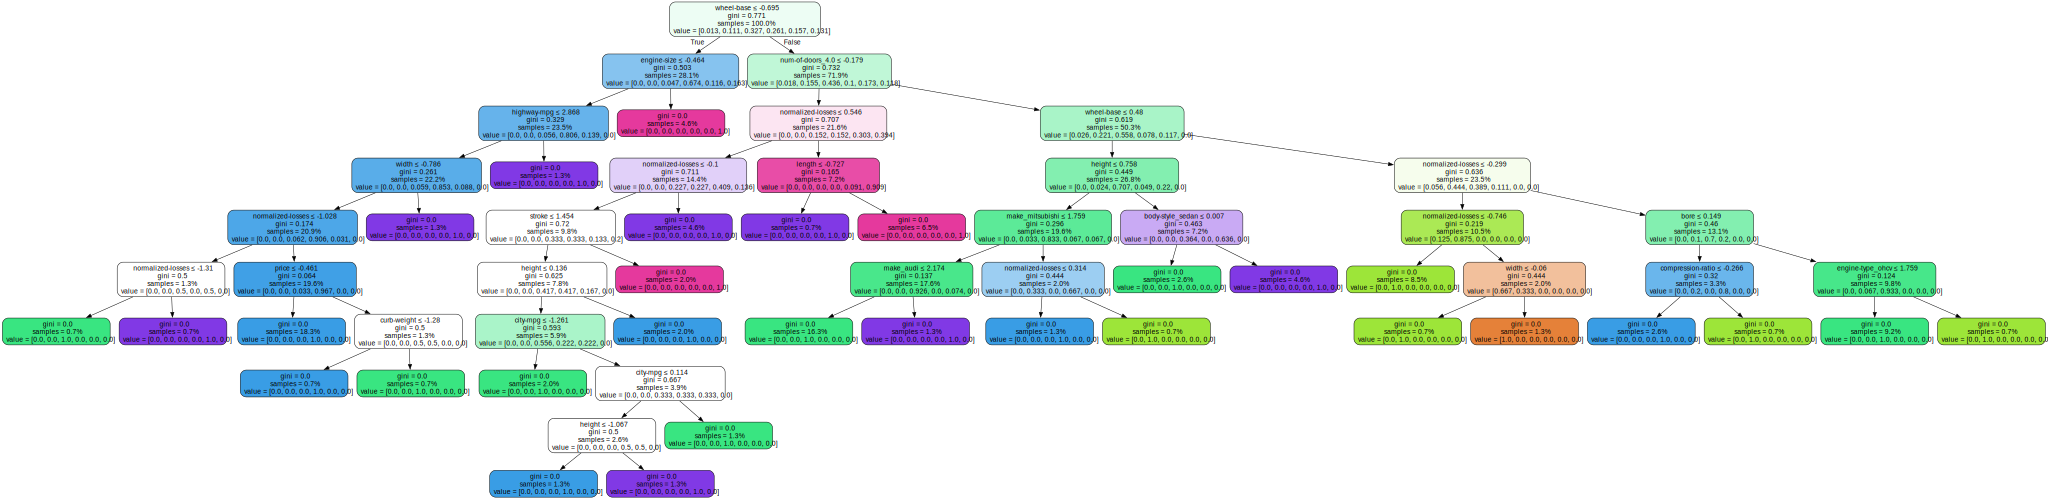

In [42]:
from sklearn.tree import export_graphviz
import graphviz
import os

os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

clf = models_df.loc[6, "model"]

dot_data = export_graphviz(
    clf,
    out_file=None,
    feature_names=clf.feature_names_in_,
    filled=True,
    rounded=True,
    special_characters=True,
    proportion=True,
)

graph = graphviz.Source(dot_data)

graph.render("decision_tree_visualization", format="png")

graph

#### Сравнить лучшие модели `KNeighborsClassifier`, `DecisionTreeClassifier`, `RandomForestClassifier` на **тестовой выборке**. Привести значения метрик $accuracy$, $precision$, $recall$, $\textit{f-measure}$.

In [43]:
models_df[["model_name", "accuracy", "precision", "recall", "f1", "model_type"]]

,model_name,accuracy,precision,recall,f1,model_type
0,Лучшая модель,0.788,0.669,0.692,0.658,Random Forest
1,Лучшая модель со всеми отфильтрованными призна...,0.769,0.653,0.682,0.647,Random Forest
2,Лучшая модель с отфильтрованными признаками,0.769,0.659,0.671,0.642,Random Forest
3,Лучшая модель с отфильтрованными признаками,0.827,0.859,0.869,0.856,KNeighbors
4,Лучшая модель со всеми отфильтрованными призна...,0.769,0.628,0.656,0.636,KNeighbors
5,Лучшая модель,0.769,0.625,0.656,0.631,KNeighbors
6,Лучшая модель,0.769,0.805,0.839,0.806,Decision Tree
7,Лучшая модель со всеми отфильтрованными призна...,0.769,0.803,0.837,0.803,Decision Tree
8,Лучшая модель с отфильтрованными признаками,0.654,0.534,0.535,0.527,Decision Tree


In [44]:
models_df["rank"] = models_df.groupby("model_type")["f1"].rank(
    method="first", ascending=False
)

models_df[models_df["rank"] == 1].sort_values(by=["f1"], ascending=False)[
    ["model_name", "accuracy", "precision", "recall", "f1", "model_type"]
]

,model_name,accuracy,precision,recall,f1,model_type
3,Лучшая модель с отфильтрованными признаками,0.827,0.859,0.869,0.856,KNeighbors
6,Лучшая модель,0.769,0.805,0.839,0.806,Decision Tree
0,Лучшая модель,0.788,0.669,0.692,0.658,Random Forest


**KNeighbors с отфильтрованными признаками оказался наилучшим классификатором** \
**Остальные модели лучше всего себя показали без отбора признаков, при этом Decision Tree оказался лучше, чем Random Forest**